In [1]:
import pandas as pd 
import numpy as np 
import re
import openpyxl
import datetime
import pickle
from functools import reduce
import os
import matplotlib.pyplot as plt
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder, LabelEncoder
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, ExtraTreesClassifier
from sklearn.feature_selection import SelectFromModel
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.metrics import f1_score, precision_score, recall_score, accuracy_score
import formatting

## Read CSV

In [2]:
df_raw = pd.read_csv('Data.csv')
df_raw.columns = [i.lower() for i in df_raw.columns.values]

## Data formatting

In [3]:
### for classification model 
df1 = df_raw.copy()

date_cols = ['issue_date','st_date']
desc_cols = ['pol_st','product_category','cover_type','prod_type','relationship','owner_gender','region_dummy']

for col in date_cols:
    df1[col] = df1[col].apply(lambda x: None if pd.isnull(x) else datetime.datetime.strptime(x,'%m/%d/%Y'))

for col in desc_cols:
    df1[col] = df1[col].apply(lambda x: str(x).lower())

print(f"dtypes:{df1.dtypes}")

df1['buyer_id'] = np.where(df1['buyer_id'].isnull(),df1['insured_id'],df1['buyer_id'])
df1['buyer_buying_for'] = np.where(df1['relationship']=='self','self','dependent')

### remove policies bought by 'EMPLOYER'

print(f"rows bf removal:{df1.shape[0]}")
df1 = df1.iloc[np.where(df1['relationship'].str.upper()!='EMPLOYER')]
print(f"rows aft removing employer purchase:{df1.shape[0]}")


### remove policies not underwritten

df1 = df1.iloc[np.where(df1['last_uw_dec'].str.strip()=='OK TO ISSUE')]
print(f"rows aft removing policies not underwritten:{df1.shape[0]}")

### remove policies with missing issue_date

df1 = df1.iloc[np.where(df1['issue_date'].notnull())]
print(f"rows aft removing policie w/o issue date:{df1.shape[0]}")

### alter st_date in case where pol_st is not inforce and st_date is ealier than issue_date
# change from original st_date value with issue_date
df1['st_date'] = np.where((df1['st_date']<df1['issue_date'])&(df1['pol_st']!='inforce'),
                          df1['issue_date'],
                          df1['st_date'])

### remove duplicate rows (same policy_ref_dummy, cover_code, cover_type, insured_id)

subset = ['policy_ref_dummy', 'cover_code', 'cover_type', 'insured_id']
df1.drop_duplicates(subset=subset,keep='first',inplace=True)
print(f"rows aft deduplicated:{df1.shape[0]}")


### flg_inforce

df1['flg_inforce'] = np.where(df1['pol_st'].str.strip()=='inforce',1.0,0.0)

### anp

df1['anp'] = df1[['premium','pay_method']].apply(lambda row: formatting.calculate_anp(row['premium'],row['pay_method']),axis=1)

### insured_amt

df1['insured_amt'] = df1['insured_amt'].apply(lambda x: 0.0 
if (pd.isnull(x) or (str(x).replace('.','').replace(',','').isdigit()==False))
else float(str(x).replace(',','')))

### age_grp

df1['owner_age_grp'] = df1['owner_age'].apply(formatting.age_grp)

### impute gender

gender_mode = df1['owner_gender'].mode()
df1['owner_gender'] = np.where(df1['owner_gender'].isnull(),gender_mode,df1['owner_gender'])

### group occupation class further

df1['owner_occupation_grp'] = df1['owner_occupation_class'].apply(formatting.occupation_grp)

### impute occupation_grp by mode of each owner_age_grp

df_agegrp_occ_mode = df1.groupby(by=['owner_age_grp','owner_occupation_grp'],as_index=False)['policy_ref_dummy'].count().rename(columns={'policy_ref_dummy':'count'})
df_agegrp_occ_mode = df_agegrp_occ_mode.sort_values(by=['owner_age_grp','count'],ascending=[1,0])
df_agegrp_occ_mode.drop_duplicates(subset='owner_age_grp',keep='first',inplace=True)
occ_mode_dict = df_agegrp_occ_mode.set_index('owner_age_grp').drop(columns='count',axis=1).to_dict('index')
df1['owner_occupation_grp'] = df1.apply(lambda row: occ_mode_dict[row['owner_age_grp']]['owner_occupation_grp']
if pd.isnull(row['owner_occupation_grp']) else row['owner_occupation_grp'],axis=1)

### create category dummies, prod_type dummies, rider dummies and dependent dummies

df1 = df1.sort_values(by=['policy_ref_dummy','cover_type','buyer_buying_for'],ascending=[1,1,0]).reset_index(drop=True)

df_cat_dummies = pd.get_dummies(df1['product_category'])
df_ul_dummies = pd.get_dummies(df1['prod_type'])
df_cover_dummies = pd.get_dummies(df1['cover_type'])
df_buyingfor_dummies = pd.get_dummies(df1['buyer_buying_for'])

dfs = [df1, df_cat_dummies, df_ul_dummies, df_cover_dummies, df_buyingfor_dummies]
df2 = reduce(lambda left,right: pd.merge(left,right,left_index=True,right_index=True,how='left'), dfs)
print(f"rows aft merged with dummies:{df2.shape[0]}")

### create insured_amt by cat, by ul-nul and by self-dependent

cat_cols = ['health','investment','protection','retirement','savings','ul','nul','self','dependent']
cat_insured = [i+'_insured_amt' for i in cat_cols]
cat_anp = [i+'_anp' for i in cat_cols]

for i,col in enumerate(cat_cols):
    df2[cat_insured[i]] = df2.apply(lambda row: row[col]*row['insured_amt'],axis=1)
    df2[cat_anp[i]] = df2.apply(lambda row: row[col]*row['anp'],axis=1)

### grouping from coverage-insured_id level to policy level
## checked that all coverages under policy share the same issue date, pay_mode and status

dim_vars = ['buyer_id','policy_ref_dummy','issue_date','st_date','pol_st','pay_mode',
            'owner_age_grp','owner_gender','owner_occupation_grp','region_dummy','flg_inforce']

def pol_agg(x):
    names = {
        'insured_amt':x['insured_amt'].sum(),
        'anp':x['anp'].sum(),
        'basic':x['basic'].sum(),
        'rider':x['rider'].sum()}
    for col in cat_cols:
        names[col] = x[col].max()
    for col in cat_insured:
        names[col] = x[col].sum()
    for col in cat_anp:
        names[col] = x[col].sum()
    return pd.Series(names, index=[i for i in names.keys()])

df3 = df2.groupby(by=dim_vars,as_index=False).apply(pol_agg)

print(f"rows aft grouped into policy level:{df3.shape[0]}")

### add policy seq

df3 = df3.sort_values(by=['buyer_id','issue_date'],ascending=[1,1]).reset_index(drop=True)
df3['policy_seq'] = df3.groupby(by=['buyer_id'])['policy_ref_dummy'].cumcount()+1

### add column list of insured_amt and anp of each type

df3['insured_amt_dummies'] = df3.apply(lambda row: [row[i] for i in cat_insured],axis=1)
df3['anp_dummies'] = df3.apply(lambda row: [row[i] for i in cat_anp],axis=1)

### list of flg_inforce, st_date, insured_amt and anp for each buyer_id

df_list_flg_inforce = df3.groupby(by='buyer_id')['flg_inforce'].apply(list).reset_index().rename(columns={'flg_inforce':'list_flg_inforce'})
df_list_st_date = df3.groupby(by='buyer_id')['st_date'].apply(list).reset_index().rename(columns={'st_date':'list_st_date'})
df_list_insured_amt = df3.groupby(by='buyer_id')['insured_amt_dummies'].apply(list).reset_index().rename(columns={'insured_amt_dummies':'list_insured_amt'})
df_list_anp = df3.groupby(by='buyer_id')['anp_dummies'].apply(list).reset_index().rename(columns={'anp_dummies':'list_anp'})

dfs = [df3, df_list_flg_inforce, df_list_st_date, df_list_insured_amt, df_list_anp]
df = reduce(lambda left,right: pd.merge(left,right,on='buyer_id',how='left'), dfs)
print(f"rows aft merged with buyer_id's level columns:{df.shape[0]}")


### drop only ul, nul, self, dependent from cat_cols_restrict

variations_to_drop = ['ul','nul','self','dependent']
cat_cols_restrict = [i for i in cat_cols if i not in variations_to_drop]

accum_insured = [i+'_acc' for i in cat_insured]
accum_anp = [i+'_acc' for i in cat_anp]
accum_cat = [i+'_acc' for i in cat_cols]

region_list = [i for i in df['region_dummy'].unique()]
gender_list = [i for i in df['owner_gender'].unique()]

age_grp_order = sorted([i for i in df['owner_age_grp'].unique()])
occupation_grp_order = sorted([i for i in df['owner_occupation_grp'].unique()],reverse=True)

### create pol_st_grp and product_category

df['pol_st_grp'] = df['pol_st'].apply(formatting.pol_st_grp)

st_cols = [i for i in df['pol_st_grp'].unique()]
accum_st = [i+'_acc' for i in st_cols]

df['product_category'] = np.where((df['protection']==1)&(df['investment']==1),
                                 'protection',df[cat_cols_restrict].idxmax(axis=1))

### create list_issue_date

df = df.sort_values(by=['buyer_id','policy_seq'],ascending=[1,1]).reset_index(drop=True)

df_list_issue_date = df.groupby(by='buyer_id')['issue_date'].apply(list).reset_index().rename(columns={'issue_date':'list_issue_date'})

print(f"rows bf merged with dummies:{df.shape[0]}")
dfs = [df, df_list_issue_date]
df = reduce(lambda left,right: pd.merge(left,right,on='buyer_id',how='left'), dfs)
print(f"rows aft merged with buyer_id's level columns:{df.shape[0]}")

### create status dummies

df_pol_st_dummies = pd.get_dummies(df['pol_st_grp'])

dfs = [df, df_pol_st_dummies]
df = reduce(lambda left,right: pd.merge(left,right,left_index=True,right_index=True,how='left'), dfs)
print(f"rows aft merged with dummies:{df.shape[0]}")


df['st_dummies'] = df.apply(lambda row: [row[i] for i in st_cols],axis=1)
df_list_pol_st = df.groupby(by='buyer_id')['st_dummies'].apply(list).reset_index().rename(columns={'st_dummies':'list_pol_st'})

dfs = [df, df_list_pol_st]
df = reduce(lambda left,right: pd.merge(left,right,on='buyer_id',how='left'), dfs)
print(f"rows aft merged with buyer_id's level columns:{df.shape[0]}")

df.drop(columns=st_cols,axis=1,inplace=True)

#-------------------------------------------------------------------------------
# Validity would be based on what is knowable at the time the customer 
# was about to buy the current product
#
# 1) all portfolio detail would need to be lagged by 1 step
#    and status need to be as of issue date of current proudct
# 2) for demographics, we can use from current product info
#
#-------------------------------------------------------------------------------

### create policy sequence lag

df['policy_seq_lag'] = df['policy_seq'].apply(lambda x: x-1)

### create product cat sequence

list_product_cat_dict = df.groupby(by='buyer_id')['product_category'].apply(list).to_frame().to_dict()['product_category']
df['list_product_cat'] = df['buyer_id'].apply(lambda x: list_product_cat_dict[x])

### create first and latest product

df['first_product_cat'] = df['list_product_cat'].apply(lambda x: x[0])
df['latest_product_cat'] = df.apply(lambda row: row['list_product_cat'][row['policy_seq_lag']-1],axis=1)

### create latest pay_mode

df['latest_pay_mode'] = df['pay_mode'].shift(1)
df['prev_buyer'] = df['buyer_id'].shift(1)

df['latest_pay_mode'] = np.where(df['prev_buyer']!=df['buyer_id'],None,df['latest_pay_mode'])
df.drop(columns='prev_buyer',axis=1,inplace=True)

### create list of relevant features

df['list_flg_valid'] = df.apply(lambda row: [bool(max([row['list_flg_inforce'][i], float(row['list_st_date'][i]>=row['issue_date'])])) if i<row['policy_seq_lag'] else False for i,v in enumerate(row['list_st_date'])],axis=1)
df['insured_amt_acc'] = df.apply(lambda row: [sum(x) for x in zip(*np.array(row['list_insured_amt'])[np.array(row['list_flg_valid'])][:row['policy_seq_lag']])],axis=1)
df['anp_acc'] = df.apply(lambda row: [sum(x) for x in zip(*np.array(row['list_anp'])[np.array(row['list_flg_valid'])][:row['policy_seq_lag']])],axis=1)

inforce_vector = [1.0 if i == 'inforce' else 0.0 for i in st_cols]
df['st_acc'] = df.apply(lambda row: [max(x) for x in zip(*[inforce_vector if row['issue_date']>=row['list_st_date'][i] else row['list_pol_st'][i] for i in range(row['policy_seq_lag'])])],axis=1)

### create cust_tenure_months

first_product_dict = df.groupby(by='buyer_id')['issue_date'].min().to_frame().to_dict()['issue_date']
df['first_issue_date'] = df['buyer_id'].apply(lambda x: first_product_dict[x])
df['cust_tenure_months'] = df.apply(lambda row: formatting.diff_month(row['issue_date'],row['first_issue_date']),axis=1)

### create cust_recency_months

df['cust_recency_months'] = df.apply(lambda row: np.nan 
if row['policy_seq_lag']==0 
else formatting.diff_month(row['issue_date'],row['list_issue_date'][row['policy_seq_lag']-1]),axis=1)

### create policy_count

df['policy_count'] = df.apply(lambda row: float(sum(row['list_flg_valid'][:row['policy_seq_lag']])),axis=1)

### remove first product record

df_xsell = df.iloc[np.where(df['policy_seq']>1)]

### create accummulated insured_amt, anp by cat and policy by status

for i,col in enumerate(accum_insured):
    df_xsell[col] = df_xsell['insured_amt_acc'].apply(lambda x: 0.0 if x==[] else x[i])

for i,col in enumerate(accum_anp):
    df_xsell[col] = df_xsell['anp_acc'].apply(lambda x: 0.0 if x==[] else x[i])

for i,col in enumerate(accum_st):
    df_xsell[col] = df_xsell['st_acc'].apply(lambda x: 0.0 if x==[] else x[i])


dtypes:policy_ref_dummy                    object
proposal_submission_date            object
first_uw_dec                        object
last_uw_dec                         object
issue_date                  datetime64[ns]
st_date                     datetime64[ns]
pol_st                              object
qry                                 object
product_category                    object
prod_type                           object
product_code                        object
product_name_l1                     object
product_name                        object
basic_cover_type                    object
cover_code                          object
cover_type                          object
cover_cat                          float64
insured_amt                         object
premium                             object
cover_term                         float64
pay_term                           float64
pay_method                          object
pay_mode                            object
pay_

/tmp/ipykernel_418434/1427649181.py:271: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_xsell[col] = df_xsell['insured_amt_acc'].apply(lambda x: 0.0 if x==[] else x[i])
/tmp/ipykernel_418434/1427649181.py:274: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_xsell[col] = df_xsell['anp_acc'].apply(lambda x: 0.0 if x==[] else x[i])
/tmp/ipykernel_418434/1427649181.py:277: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = val

## Get feature list

In [4]:
all_features = [i for i in accum_insured if 'nul' not in i] +\
     [i for i in accum_anp if 'nul' not in i] + [i for i in accum_st] +\
['policy_count','cust_tenure_months','cust_recency_months','first_product_cat',
'latest_product_cat','owner_age_grp','owner_gender','owner_occupation_grp','region_dummy']
target = 'product_category'
abt_vars = [i for i in all_features] + [target]

df_abt = df_xsell[abt_vars].reset_index(drop=True)

## Feature selection

In [5]:
# numeric
type_dict = df_abt.dtypes.to_frame().to_dict()[0]

numeric_features = []
for key,val in type_dict.items():
    if val in [np.float_,np.int_]:
        if key not in numeric_features:
            numeric_features.append(key)

# numeric_transformer = StandardScaler()

num_pipeline = Pipeline([
  ('imputer', SimpleImputer(missing_values=np.nan, strategy='constant',fill_value=0)),
  ('scaler', StandardScaler())
])

# ordinal
ordinal_features = ['owner_age_grp','owner_occupation_grp']

#levels for ordinals
cat_age_lvl = [age_grp_order]
cat_occupation_lvl = [occupation_grp_order]

# categorical
cat_first_product = [cat_cols_restrict]
cat_latest_product = [cat_cols_restrict]
cat_region = [region_list]
cat_gender = [gender_list]


# Prepare scaler, preprocessor
preprocessor = ColumnTransformer(
    transformers=[
        ('num', num_pipeline, numeric_features),
        ('owner_age_grp',OrdinalEncoder(categories=cat_age_lvl), ['owner_age_grp']),
        ('owner_occupation_grp',OrdinalEncoder(categories=cat_occupation_lvl), ['owner_occupation_grp']),
        ('first_product_cat', OneHotEncoder(categories=cat_first_product,handle_unknown='ignore'), ['first_product_cat']),
        ('latest_product_cat', OneHotEncoder(categories=cat_latest_product,handle_unknown='ignore'), ['latest_product_cat']),
        ('region_dummy', OneHotEncoder(categories=cat_region,handle_unknown='ignore'), ['region_dummy']),
        ('owner_gender', OneHotEncoder(categories=cat_gender,handle_unknown='ignore'), ['owner_gender'])
    ]
)

# Prepare transformed column names

transformers = preprocessor.transformers

def get_features_names(transformer):
    transformed_cols = []
    steps = range(len(transformer))
    for step in steps:
        if step==0:
            num_cols = transformers[step][-1]
            transformed_cols = transformed_cols + [i for i in num_cols]
        elif type(transformers[step][1]) == type(OrdinalEncoder()):
            ordinal_cols = transformers[step][-1]
            transformed_cols = transformed_cols + [i for i in ordinal_cols]
        else:
            new_cols = [i+'_'+j for j in transformers[step][1].categories[0] for i in transformers[step][-1]]
            transformed_cols = transformed_cols + [i for i in new_cols]
    return transformed_cols

transformed_cols = get_features_names(transformers)


## Train-test split

X = df_abt[all_features]
Y = df_abt[target]

X_train, X_test, y_train, y_test = train_test_split(X, Y, 
                                                    random_state=9000, 
                                                    test_size=0.2,
                                                    stratify=Y)

## get selected features

clf_feat_select= ExtraTreesClassifier(n_estimators=100,
                                      max_depth=3,
                                      min_samples_leaf=3,
                                      random_state=50)

feat_select_model = SelectFromModel(clf_feat_select, threshold='10*median')

feat_select_pipe = Pipeline(steps=[('preprocessor', preprocessor),
                                    ('feat_select',  feat_select_model)])

feat_select_pipe.fit(X_train, y_train)

feat_accept_filter = feat_select_pipe.named_steps['feat_select'].get_support()
selected_feats = list(np.array(transformed_cols)[feat_accept_filter])

print(f"no. of tranformed features:{len(transformed_cols)}")
print(f"no. of model-selected features:{len(selected_feats)}")
print(f"selected_feats:{selected_feats}")

no. of tranformed features:62
no. of model-selected features:12
selected_feats:['investment_insured_amt_acc', 'lapsed_acc', 'cust_tenure_months', 'cust_recency_months', 'owner_age_grp', 'first_product_cat_investment', 'first_product_cat_protection', 'first_product_cat_retirement', 'latest_product_cat_investment', 'latest_product_cat_protection', 'latest_product_cat_retirement', 'region_dummy_region_10']


# Pipeline
## 1) Preprocessor: transform features, features selection
## 2) Classifier: GradientBoostingClassifier, RandomForestClassifier

In [6]:
pipe = Pipeline(steps=[('full_preprocessor', feat_select_pipe),
                       ('clf',GradientBoostingClassifier())]) #dummy

k_fold = StratifiedKFold(n_splits=5, shuffle=True, random_state=0)

# Hyperparameters 

param_grid = [{'clf':[GradientBoostingClassifier()],
            'clf__n_estimators': [100],
            'clf__max_depth': [3,4,5],
            'clf__min_samples_leaf': [2,3],
            'clf__learning_rate': [0.1,0.05,0.03,0.01]
            },
            {'clf':[RandomForestClassifier()],
            'clf__n_estimators': [500],
            'clf__max_depth': [4,5,6],
            'clf__max_features':['sqrt'],
            'clf__min_samples_leaf': [2,3]}]

best_model = GridSearchCV(pipe, param_grid = param_grid, scoring='accuracy',
                          cv = k_fold, n_jobs = -1, verbose = 1)

# fit pipeline
best_model.fit(X_train, y_train)

# score
y_pred = best_model.predict(X_test)

Fitting 5 folds for each of 30 candidates, totalling 150 fits


In [7]:
def get_kpis(pipeline,y_pred):

    # Calculat Accuracy, Precision, Recall, F1 Score

    # metrics = precision_recall_fscore_support(y_test, pipeline.predict(X_test))
    accuracy =accuracy_score(y_test, y_pred)
    precision =precision_score(y_test, y_pred, average='weighted',zero_division=0)
    recall =recall_score(y_test, y_pred, average='weighted',zero_division=0)
    f1 =f1_score(y_test, y_pred, average='weighted',zero_division=0)

    print(f"classifier: {pipeline.best_estimator_.named_steps['clf']}")
    print("Model Accuracy: {:.3f}".format(accuracy))
    print("Precision of postive cases: {:.2f}".format(precision))
    print("Recall of postive cases: {:.2f}".format(recall))
    print("F1 Score of postive cases: {:.2f}".format(f1))

get_kpis(best_model,y_pred)

classifier: GradientBoostingClassifier(learning_rate=0.01, max_depth=4, min_samples_leaf=2)
Model Accuracy: 0.751
Precision of postive cases: 0.75
Recall of postive cases: 0.75
F1 Score of postive cases: 0.74


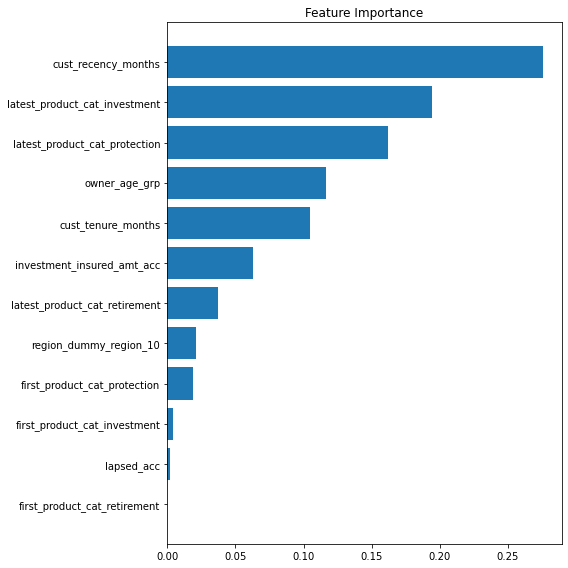

In [8]:
def get_feature_importance(clf,y_pred):
    '''Get Feature importance data using feature_importances_ attribute'''
    feat_accept_filter = feat_select_pipe.named_steps['feat_select'].get_support()
    selected_feats = list(np.array(transformed_cols)[feat_accept_filter])

    feature_importance = clf.feature_importances_
    sorted_idx = np.argsort(feature_importance)
    pos = np.arange(sorted_idx.shape[0]) + .5
    fig = plt.figure(figsize=(8, 8))
    plt.barh(pos, feature_importance[sorted_idx], align='center')
    plt.yticks(pos, np.array(selected_feats)[sorted_idx])
    plt.title('Feature Importance')
    fig.tight_layout()

get_feature_importance(best_model.best_estimator_.named_steps['clf'],y_pred)

## Save pipeline

In [ ]:
with open('./trg/xsell_pipeline.pkl', 'wb') as f:
    pickle.dump(best_model, f)

In [13]:
df['product_category'].unique()

array(['retirement', 'protection', 'investment', 'health', 'savings'],
      dtype=object)